### Imports

In [1]:
import pickle
import os, os.path
import numpy as np
import scipy.stats
import time
import matplotlib.pyplot as plt
import colorsys
import colorio
import matplotlib.colors as colors
from PIL import Image

import scipy
import pylab
import matplotlib.cm as cm
import seaborn as sns
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform

cmap = cm.plasma(np.linspace(0.0, 1, 3))
sch.set_link_color_palette([colors.rgb2hex(rgb[:3]) for rgb in cmap])

### Function Defintions

In [3]:
jzazbz_map = np.load('jzazbz_array.npy', encoding = 'latin1')

def rgb_array_to_jzazbz_array(rgb_array):
    jzazbz_array = np.zeros(rgb_array.shape)
    for i in range(rgb_array.shape[0]):
        for j in range(rgb_array.shape[1]):
            jzazbz_array[i][j] = jzazbz_map[rgb_array[i][j][0]][rgb_array[i][j][1]][rgb_array[i][j][2]]
    return jzazbz_array

In [3]:
def get_img_dict(words, path_to_words, compress=True, compress_dim=300, complexity_dim=3):
    img_dict = {}
    img_array_dict = {}
    img_array_complexity_dict = {}
    for word in words:
        img = []
        img_array = []
        img_array_complexity = []
        folder = path_to_words + '{}'.format(word)
        pics = [name for name in os.listdir(folder) if os.path.isfile(os.path.join(folder, name))]
        for pic in pics:
            filename = 'downloads/{}/{}'.format(word,pic)
            if os.path.splitext(filename)[1] != '.svg':
                try:
                    img_raw = Image.open(filename)
                    if compress == True:
                        img_compress = img_raw.resize((compress_dim,compress_dim),Image.ANTIALIAS)
                        if np.shape(np.array(img_compress)) == (compress_dim, compress_dim, 3):
                            img.append(img_compress)
                            img_array.append(np.array(img_compress))
                            img_compress_complexity = img_raw.resize((complexity_dim,complexity_dim),Image.ANTIALIAS)
                            img_array_complexity.append(np.array(img_compress_complexity))
                except:
                    pass
        img_dict[word] = img
        img_array_dict[word] = img_array
        img_array_complexity_dict[word] = img_array_complexity
    return img_dict, img_array_dict, img_array_complexity_dict

In [4]:
def get_color_distributions(img_dict, jzazbz=True, hsv=True, rgb=True, spacing=36):
    jzazbz_dict = {}
    jzazbz_dict_dist = {}
    hsv_dict = {}
    rbg_dict = {}
    if jzazbz == True:
        for key in img_dict:
            jzazbz = []
            dist_array = []
            for i in range(len(img_dict[key])):
                jzazbz_temp = rgb_array_to_jzazbz_array(img_array_dict[key][i])
                jzazbz.append(jzazbz_temp)
                dist = np.ravel(np.histogramdd(np.reshape(jzazbz_temp[:,:,:],(90000,3)), 
                                      bins=(np.linspace(0,0.167,3),np.linspace(-0.1,0.11,3),
                                           np.linspace(-0.156,0.115,3)), density=True)[0])
                dist_array.append(dist)
            jzazbz_dict[key] = jzazbz
            jzazbz_dict_dist[key] = dist_array#jzazbz
            #distribution_dict[key] = dist_array
    if hsv == True:
        h_dict, s_dict, v_dict = {}, {}, {}
        for key in img_dict:
            dist_array, h, s, v = [], [], [], []
            for i in range(len(img_dict[key])):
                hsv_array = colors.rgb_to_hsv(img_array_dict[key][i]/255.)
                dist = np.histogram(360.*np.ravel(hsv_array[:,:,0]),
                                    bins=np.arange(0,360+spacing,spacing),
                                    density=True)[0]
                dist_array.append(dist)
                h.append(np.mean(np.ravel(hsv_array[:,:,0])))
                s.append(np.mean(np.ravel(hsv_array[:,:,1])))
                v.append(np.mean(np.ravel(hsv_array[:,:,2])))
            hsv_dict[key] = dist_array
            #h_dict[key], s_dict[key], v_dict[key] = h, s, v
    if rgb == True:
        rgb_dict = {}
        rgb_dict_dist = {}
        for key in img_dict:
            rgb = []
            dist_array = []
            for i in range(len(img_dict[key])):
                r = np.sum(np.ravel(img_dict[key][i][:,:,0]))
                g = np.sum(np.ravel(img_dict[key][i][:,:,1]))
                b = np.sum(np.ravel(img_dict[key][i][:,:,2]))
                tot = 1.*r+g+b
                rgb.append([r/tot,g/tot,b/tot])
                dist = np.ravel(np.histogramdd(np.reshape(img_array_dict[key][i],(90000,3)), 
                                      bins=(np.linspace(0,255,3),np.linspace(0,255,3),
                                           np.linspace(0,255,3)), density=True)[0])
                dist_array.append(dist)
            rgb_dict[key] = rgb
            rgb_dict_dist[key] = dist_array
#        return jzazbz_dict, distribution_dict, h_dict, s_dict, v_dict, rgb_dict
    return jzazbz_dict, jzazbz_dict_dist, hsv_dict, rgb_dict, rgb_dict_dist

In [5]:
def compress_img_array(words, img_array_dict, compress_dim=300):
    compressed_img_array_dict = {}
    for word in words:
        compressed_img_array = np.zeros((compress_dim,compress_dim,3))
        for n in range(len(img_array_dict[word])):
            if np.shape(img_array_dict[word][n]) == (compress_dim, compress_dim, 3):
                for i in range(compress_dim):
                    for j in range(compress_dim):
                        compressed_img_array[i][j] += img_array_dict[word][n][i][j]/(1.*len(img_array_dict[word]))
        compressed_img_array_dict[word] = compressed_img_array
    return compressed_img_array_dict

In [6]:
def cross_entropy_between_images(rgb_dict, symmetrized=True):
    entropy_dict = {}
    entropy_dict_js = {}
    for key in rgb_dict:
        entropy_array = []
        entropy_array_js = []
        for i in range(len(rgb_dict[key])):
            for j in range(len(rgb_dict[key])):
                if symmetrized == True:
                    mean = (rgb_dict[key][i] + rgb_dict[key][j])/2.
                    entropy_array.append((scipy.stats.entropy(rgb_dict[key][i],rgb_dict[key][j])+scipy.stats.entropy(rgb_dict[key][j],rgb_dict[key][i]))/2.)
                    entropy_array_js.append((scipy.stats.entropy(rgb_dict[key][i],mean) + scipy.stats.entropy(rgb_dict[key][j],mean))/2.)
                else:
                    entropy_array.append(scipy.stats.entropy(rgb_dict[key][i],rgb_dict[key][j]))
        entropy_dict[key] = entropy_array
        entropy_dict_js[key] = entropy_array_js
    return entropy_dict, entropy_dict_js

In [7]:
def cross_entropy_between_labels(rgb_dict, words, symmetrized=True):
    mean_rgb_dict = {}
    for key in rgb_dict:
        mean_rgb_array = np.mean(np.array(rgb_dict[key]),axis=0)
        mean_rgb_dict[key] = mean_rgb_array
    labels_entropy_dict = {}
    labels_entropy_dict_js = {}
    color_sym_matrix = []
    color_sym_matrix_js = []
    for word1 in words:
        row = []
        row_js = []
        for word2 in words:
            if symmetrized == True:
                mean = (mean_rgb_dict[word1] + mean_rgb_dict[word2])/2.
                entropy = (scipy.stats.entropy(mean_rgb_dict[word1],mean_rgb_dict[word2])+scipy.stats.entropy(mean_rgb_dict[word2],mean_rgb_dict[word1]))/2.
                entropy_js = (scipy.stats.entropy(mean_rgb_dict[word1],mean) + scipy.stats.entropy(mean_rgb_dict[word2],mean))/2.
            else:
                entropy = scipy.stats.entropy(mean_rgb_dict[word1],mean_rgb_dict[word2])
                entropy_js = []
            row.append(entropy)
            row_js.append(entropy_js)
            labels_entropy_dict[word1 + word2] = entropy
            labels_entropy_dict_js[word1 + word2] = entropy_js
        color_sym_matrix.append(row)
        color_sym_matrix_js.append(row_js)
    return labels_entropy_dict, color_sym_matrix, labels_entropy_dict_js, color_sym_matrix_js

### Analysis

In [8]:
path_to_words = 'downloads/'
words = ['atlantis']

In [10]:
img_dict, img_array_dict, img_array_complexity_dict = get_img_dict(words, path_to_words)

jzazbz_dict, jzazbz_dict_dist, hsv_dict, rgb_dict, rgb_dict_dist = get_color_distributions(img_array_dict, jzazbz=True, spacing=36)
#rgb_dict_complexity = get_rgb_distributions(img_array_complexity_dict)

#entropy_dict = cross_entropy_between_images(distribution_dict, symmetrized=True)
#complexity_dict = cross_entropy_between_images(rgb_dict_complexity)

#compressed_img_array_dict = compress_img_array(words, img_array_dict)
#cross_entropy_between_labels_dict, cross_entropy_matrix, cross_entropy_between_labels_dict_js, cross_entropy_matrix_js = cross_entropy_between_labels(distribution_dict, symmetrized=True)
#cross_complexity_between_labels_dict = cross_entropy_between_labels(rgb_dict_complexity)

### Visualization

In [ ]:
index = 1
word = words[index]

In [ ]:
spacing = 10
bins = np.arange(0,360+spacing,spacing)
centers = (bins[:-1] + bins[1:]) / 2

meanhsvcolor = colorsys.hsv_to_rgb(np.mean(h_dict[word],axis=0),
                                   np.mean(s_dict[word],axis=0),
                                   np.mean(v_dict[word],axis=0))

meanrgbcolor = np.mean(np.array(rgb_dict[words[0]]),axis=0)
    
rgbcolors = []
for i in range(len(centers)):
    rgbcolors.append(colorsys.hsv_to_rgb(centers[i]/360.,
                                         np.mean(s_dict[word],axis=0),
                                         np.mean(v_dict[word],axis=0)))

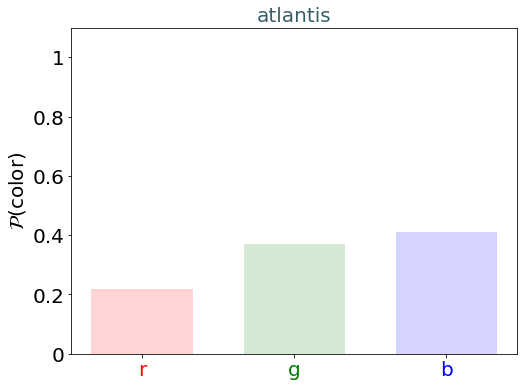

In [15]:
f,ax = plt.subplots(1,1,figsize=(8,6))

alpha = 0.17
N = 360

avg_rgb = np.mean(np.array(distribution_dict[word]),axis=0)

ind = np.linspace(0,N,N/spacing) #the x locations for the groups
width = spacing #the width of the bars

p1 = ax.bar(ind, spacing*avg_rgb, width, color=rgbcolors)

#ax.set_ylim(0,1.1)
ax.set_title('{}'.format(word), fontsize=20, color=meanrgbcolor)
ax.set_xticks(centers[::5])
ax.set_xticklabels(centers[::5].astype(int), fontsize=16)
#ax.set_yticks((0,0.2,0.4,0.6,0.8,1.0))
#ax.set_yticklabels(('0', '0.2', '0.4', '0.6', '0.8', '1'), fontsize=20)

[t.set_color(i) for (i,t) in
 zip(rgbcolors[::5],ax.xaxis.get_ticklabels())]

plt.ylabel(r'$\mathcal{P}(\rm{hue})$',fontsize=20)
plt.subplots_adjust(wspace=0.25)

plt.savefig('atlantis.pdf')
plt.show()

/Users/eon/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


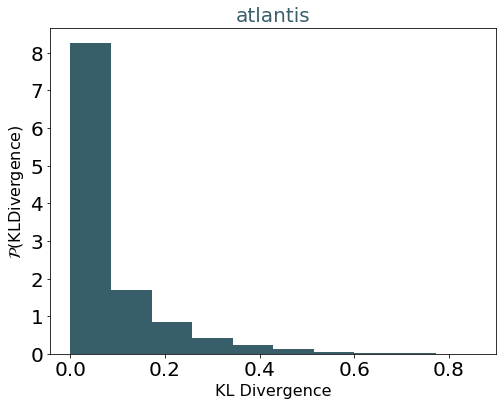

In [16]:
plt.figure(figsize=(8,6))

plt.hist(np.array(entropy_dict[word])[~np.isinf(entropy_dict[word])],density=True,
         color=meanrgbcolor, alpha=1.)
#plt.hist(complexity_dict['terrorism'],normed=True,color=(np.mean(np.array(rgb_dict['terrorism']),axis=0)),alpha=0.5)

plt.title('{}'.format(word), fontsize=20,color=meanrgbcolor)
plt.xlabel('KL Divergence', fontsize=16)
plt.ylabel(r'$\mathcal{P}(\rm{KL Divergence})$', fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

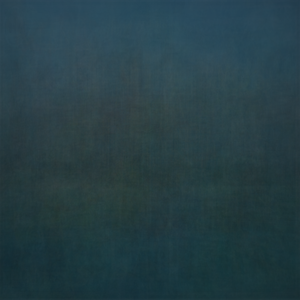

In [26]:
Image.fromarray(compressed_img_array_dict[words[0]].astype(np.uint8))

/Users/eon/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


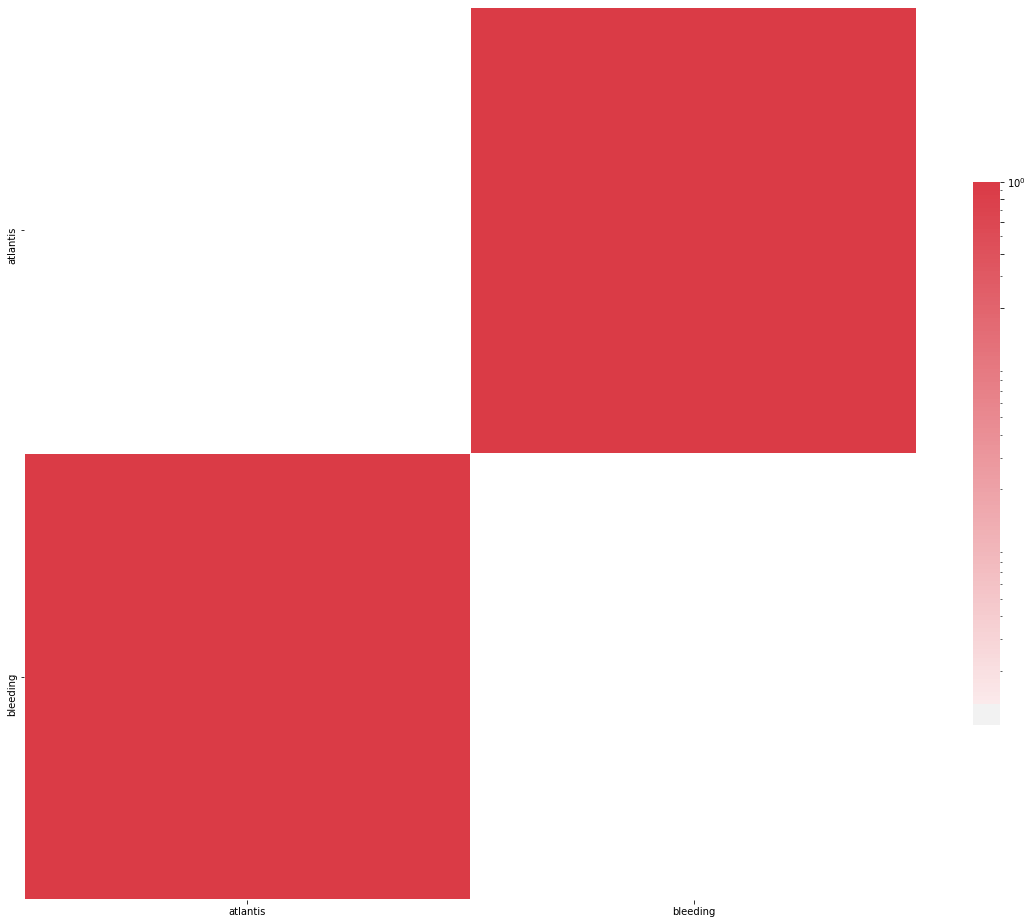

In [28]:
SymMat = np.matrix(cross_entropy_matrix)
A = np.eye(len(words))
mask = A == 0
fig = plt.figure(figsize=(20,20))
SymMat2 = SymMat/SymMat[np.logical_and(~np.isnan(SymMat),SymMat!=0)].min()#np.log(SymMat)-np.log(SymMat[np.logical_and(~np.isnan(SymMat),SymMat!=0)]).min()
#SymMat2 = SymMat2-A
np.fill_diagonal(SymMat2, 0)
SymMat2 = 1./SymMat2
np.fill_diagonal(SymMat2, 1e-3)
SymMat2[np.isinf(SymMat2)] = SymMat2[~np.isinf(SymMat2)].max()
SymMat2 = SymMat2/SymMat2.max()
np.fill_diagonal(SymMat2, SymMat2.min())
#SymMat2[np.isnan(SymMat2)] = 0
vmax = SymMat2.max()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(SymMat2, cmap=cmap, norm=colors.LogNorm(vmin=SymMat2.min(),vmax=SymMat2.max()), center=0, mask=~mask,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, xticklabels = words, yticklabels=words)